In [ ]:
from nbdev import *

In [24]:
%nbdev_default_export basic_mrna_content_regression

# mRNA content regression

> API details.

In [9]:
%nbdev_hide
from nbdev.showdoc import *

In [10]:
# %load common.py
%nbdev_export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from importlib import reload
from ehv import core

numpy.random.seed(42)

In [31]:
%nbdev_export

import time
import fcsparser
import sklearn.linear_model
import sklearn.model_selection
from functools import partial
import scipy.stats
from ehv import splits, mrna_content_regression
from joblib import load

In [40]:
logging.basicConfig(level=logging.INFO)

In [13]:
core.load_config("../config_cn1346.yml")

In [14]:
meta, df = fcsparser.parse(core.FCS_NONINTENSITY)
df_meta = df[["label", "replicate", "timepoint"]].astype(int)
df_meta["timepoint"] = df_meta["timepoint"].map(lambda a: meta["timepoint"].split(",")[a])
df_meta["replicate"] = df_meta["replicate"].map(lambda a: meta["replicate"].split(",")[a])
df = df.drop(columns=["label", "replicate", "timepoint"])

In [22]:
_, fluor_df = fcsparser.parse(core.FCS_FLUOR)

# mRNA content targets

In [14]:
_, fluor_df = fcsparser.parse(core.FCS_FLUOR)

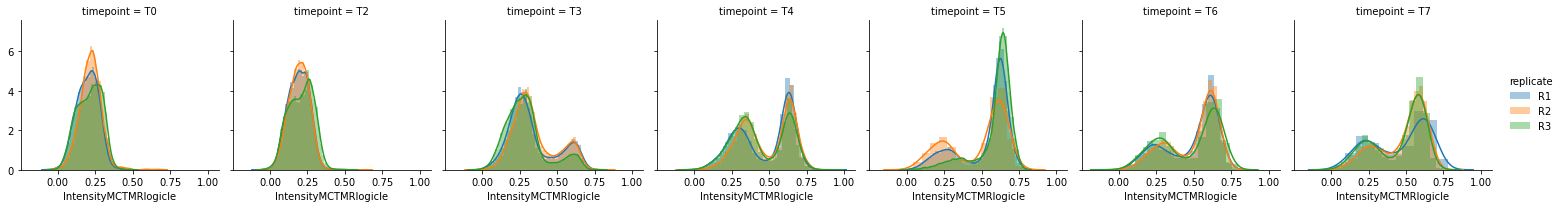

In [15]:
grid = seaborn.FacetGrid(col="timepoint", hue="replicate", data=pandas.concat([fluor_df, df_meta], axis=1))
grid.map(seaborn.distplot, "IntensityMCTMRlogicle")
grid.add_legend()

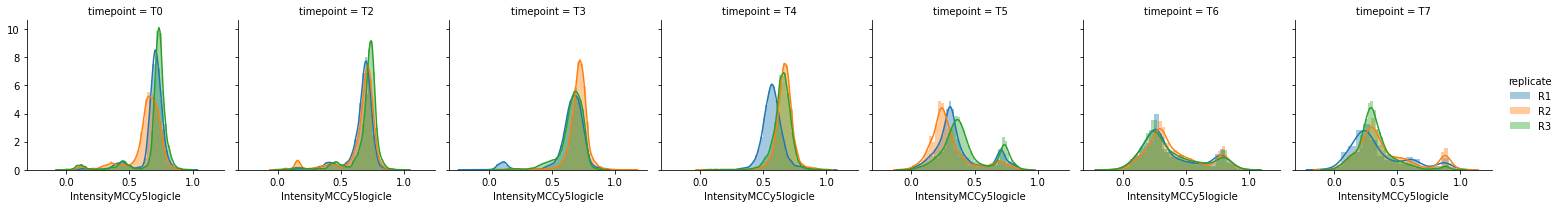

In [16]:
grid = seaborn.FacetGrid(col="timepoint", hue="replicate", data=pandas.concat([fluor_df, df_meta], axis=1))
grid.map(seaborn.distplot, "IntensityMCCy5logicle")
grid.add_legend()

# BF regression on targets

In [19]:
bf_df = df.filter(regex="(i?).*BF.*")

In [20]:
outer_fold, inner_folds = load(core.FOLDS)

In [25]:
bf_tmr_funcs = splits.preprocess_funcs(bf_df, fluor_df["IntensityMCTMRlogicle"], outer_fold, inner_folds)

# Linear regression

## Lasso

In [43]:
%nbdev_export
def run_lasso_optimization(i, j, X, y, X_test, y_test, inner_fold, inner_funcs, outer_func):
    # find best alpha
    model = sklearn.linear_model.LassoCV(fit_intercept=True, n_jobs=3, max_iter=3000, cv = sklearn.model_selection.PredefinedSplit(inner_fold))
    model.fit(X, y)

    # retrain lasso with optimal alpha on full train data
    logging.getLogger(__name__).info(f"Optimal alpha: {model.alpha_}")
    model = sklearn.linear_model.Lasso(fit_intercept=False, alpha=model.alpha_, max_iter=3000)
    model.fit(outer_func[0](X), outer_func[1](y))

    y_test_pred = model.predict(outer_func[0](X_test))

    mse = sklearn.metrics.mean_squared_error(outer_func[1](y_test), y_test_pred)

    return mse

In [44]:
scores = mrna_content_regression.nested_cross_validation_with_hyperparam_optimization(bf_df, fluor_df["IntensityMCTMRlogicle"], 9, run_lasso_optimization)

INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 0, inner fold repeat 1/3
INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 0, inner fold repeat 2/3
INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 0, inner fold repeat 3/3
INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 1, inner fold repeat 1/3
INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 1, inner fold repeat 2/3
INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 1, inner fold repeat 3/3
INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 2, inner fold repeat 1/3
INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 2, inner fold repeat 2/3
INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 2, inner fold repeat 3/3
/home/maximl/.conda/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1283: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessi

In [45]:
scores

[[0.025498768, 0.025498768, 0.025498768],
 [0.021428995, 0.021428995, 0.021428995],
 [0.02396284, 0.02396284, 0.02396284]]

## Ridge

In [38]:
%nbdev_export
def run_ridge_optimization(i, j, X, y, X_test, y_test, inner_fold, inner_funcs, outer_func):
    # find best alpha
    model = sklearn.linear_model.RidgeCV(normalize=True, n_jobs=3, max_iter=5000, cv = sklearn.model_selection.PredefinedSplit(inner_fold))
    model.fit(X, y)

    # retrain lasso with optimal alpha on full train data
    logging.getLogger(__name__).info(f"Optimal alpha: {model.alpha_}")
    model = sklearn.linear_model.Ridge(fit_intercept=False, alpha=model.alpha_, max_iter=5000)
    model.fit(outer_func[0](X), outer_func[1](y))

    y_test_pred = model.predict(outer_func[0](X_test))

    mse = sklearn.metrics.mean_squared_error(outer_func[1](y_test), y_test_pred)

    return mse

In [41]:
scores = mrna_content_regression.nested_cross_validation_with_hyperparam_optimization(bf_df, fluor_df["IntensityMCTMRlogicle"], 9, run_ridge_optimization)

INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 0, inner fold repeat 1/3
INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 0, inner fold repeat 2/3
INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 0, inner fold repeat 3/3
INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 1, inner fold repeat 1/3
INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 1, inner fold repeat 2/3
INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 1, inner fold repeat 3/3
INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 2, inner fold repeat 1/3
INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 2, inner fold repeat 2/3
INFO:ehv.mrna_content_regression:Hyper param tuning on outer fold 2, inner fold repeat 3/3
/home/maximl/.conda/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1283: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessi

# Model comparison

In [3]:
%nbdev_export

metric_funcs = [
    metrics.explained_variance_score,
    metrics.max_error,
    metrics.mean_absolute_error,
    metrics.mean_squared_error,
    metrics.mean_squared_error,
    metrics.median_absolute_error,
    metrics.r2_score
]

def compute_metrics(paths, log):
    values = {f.__name__: [] for f in metric_funcs}
    for i, (path, Xy) in enumerate(zip(paths, Xy_test)):
        regr = load(path).predict(Xy[0])
        for f in metric_funcs:
            values[f.__name__].append(f(Xy[1], regr))

    if log:
        for k,v in values.items():
            print(f"{k}: {numpy.mean(v)} +- {scipy.stats.sem(v)}")
        print("----")

    return values

NameError: name 'metrics' is not defined